# RoboMarkt

We start with an exact model

In [1]:
import mip
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt, pow
from robomarkt_0 import Cx, Cy, usable, Dc, maxdist, mindist, maxstores, Fc, Vc

n = len(usable)
villages = range(n)

print(n)

usable = [1 if usable[i] else 0 for i in villages]

D = [[sqrt(pow(Cx[i]-Cx[j],2) + pow(Cy[i]-Cy[j], 2)) for i in villages] for j in villages]   # Euclidean distances matrix

max_trucks_n = n//maxstores + (1 if n%maxstores > 0 else 0)   #needed trucks
trucks = range(max_trucks_n)

m_exact = mip.Model()   #exact model

# VARIABLES

stores = [m_exact.add_var(var_type=mip.BINARY) for i in villages]    #stores[i] tells if a store is built in village i
links  = [[m_exact.add_var(var_type=mip.BINARY) for i in villages] for j in villages]    #links[i][j] tells if village i has store j as assigned store (a store no further than maxdist km away)
#hired_trucks = [m_exact.add_var(var_type=mip.BINARY) for t in trucks]     #hired_trucks[t] = 1 if truck t is used
#trucks_paths = [[[m_exact.add_var(var_type=mip.BINARY) for i in villages] for j in villages] for t in trucks]   #trucks_paths[t][i][j] = 1 if truck t uses the road between village i and village j
#trucks_visits = [[m_exact.add_var(var_type=mip.BINARY) for i in villages] for t in trucks]   #trucks_visits[t][i] = 1 if trucks t refills store i


# CONSTRAINTS

# we can build stores only where we have the permission
for i in villages:
    m_exact.add_constr(stores[i] <= usable[i])

# a store is built in village 0 for company image reasons
m_exact.add_constr(stores[0] == 1)

# assign each village to a store
for i in villages:
    m_exact.add_constr(mip.xsum(links[i][j] for j in villages) == 1)  

# the store has to be existing
for j in villages:
    m_exact.add_constr(mip.xsum(links[i][j] for i in villages) <= n*stores[j])

# the distance between each village and the assigned store must at most maxdist
for i in villages:
    m_exact.add_constr(mip.xsum(D[i][j]*links[i][j] for j in villages) <= maxdist)

# the distance between stores has to be at least mindist
for i in villages:
    for j in [j for j in villages if j != i]:
        m_exact.add_constr(D[i][j] >= mindist*(stores[i] + stores[j] - 1))

'''
# we define a path only for the trucks we actually use
for t in trucks:
    m_exact.add_constr(mip.xsum(trucks_paths[t][i][j] for i in villages for j in villages) <= n*n*hired_trucks[t])

for t in trucks:
    m_exact.add_constr(mip.xsum(trucks_visits[t][i] for i in villages) <= n*hired_trucks[t])

# a single truck can visit up to maxstores stores
for t in trucks:
    m_exact.add_constr(mip.xsum(trucks_visits[t][i] for i in villages) <= maxstores + 1)

# every store has to be refilled
for i in range(1,n):    #the base location is considered automatically refilled
    m_exact.add_constr(mip.xsum(trucks_visits[t][i] for t in trucks) == stores[i])

# the path of each truck is an Hamiltonian cicle between the chosen stores
for t in trucks:
    for i in villages:
        m_exact.add_constr(mip.xsum(trucks_paths[t][j][i] for j in villages) == trucks_visits[t][i])  # a single entry path
        m_exact.add_constr(mip.xsum(trucks_paths[t][i][j] for j in villages) == trucks_visits[t][i])  # a single exit path

# the village at index 0 is part of this path as it is the base of the company
for t in trucks:
    m_exact.add_constr(trucks_visits[t][0] == hired_trucks[t]) 

# OBJECTIVE FUNCTION

m_exact.objective = mip.minimize(mip.xsum(Dc[i]*stores[i] for i in villages) + mip.xsum(Fc*hired_trucks[t] for t in trucks) + mip.xsum(Vc*trucks_paths[t][i][j] for t in trucks for i in villages for j in villages))
'''

m_exact.objective = mip.minimize(mip.xsum(Dc[i]*stores[i] for i in villages))


m_exact.optimize()
print(m_exact.objective_value)


An error occurred while loading the CBC library:	 cannot load library 'C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\mip\libraries\win64\libCbcSolver-0.dll': error 0x7e



99


NameError: name 'cbclib' is not defined

Visualization of the optimal solution

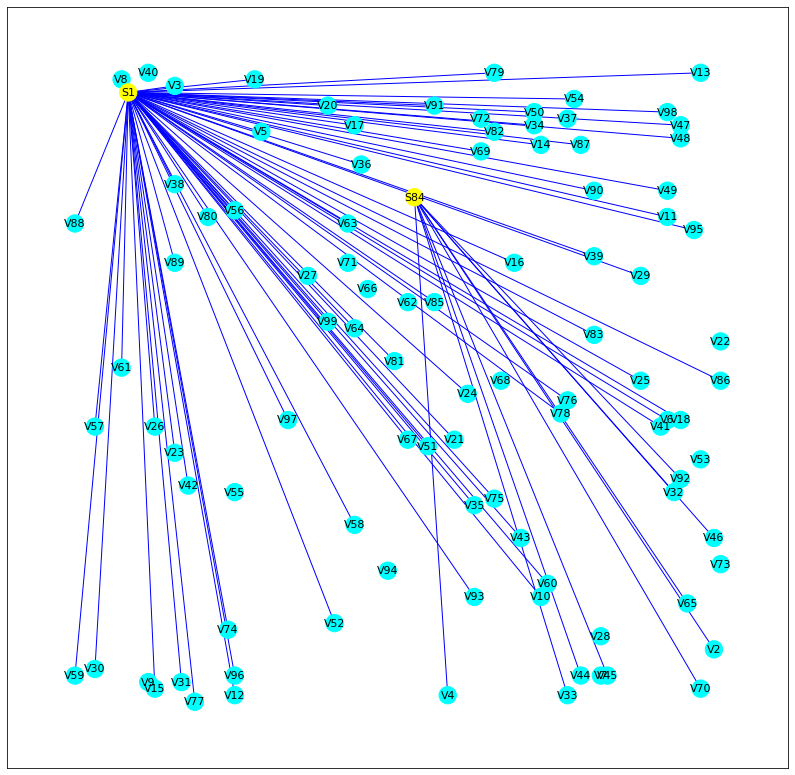

In [ ]:
g = nx.Graph()

V = [i for i in villages if stores[i].x == 0]
S = [i for i in villages if stores[i].x == 1]

g.add_nodes_from([f'V{i+1}' for i in V])
g.add_nodes_from([f'S{i+1}' for i in S])
positions = {**{f'V{i+1}' : (Cx[i], Cy[i]) for i in V}, **{f'S{i+1}' : (Cx[i], Cy[i]) for i in S}}

node_colors = ['cyan' for i in V] + ['yellow' for i in S]

links_e = [(f'V{i+1}', f'S{j+1}') for i in V for j in S if links[i][j].x == 1]  
g.add_edges_from(links_e)

#paths_e = [(f'S{i+1}', f'S{j+1}') for i in S for j in S if 1 in [trucks_paths[t][i][j].x for t in trucks]]
#g.add_edges_from(paths_e)

edge_colors = ['blue' for _ in links_e] #+ ['red' for _ in paths]

plt.figure(1, figsize=(14,14))
nx.draw_networkx(g, font_size=11, pos=positions, edge_color=edge_colors, node_color=node_colors)
plt.show()
